把BJUT、CWRU、IMS三个数据集划分成2048长度的样本，和（2048，256）的CWT矩阵

2048信号 reshape to (2048,1), （64，64）矩阵的压缩为：（64，64），reshape to (64*64,1)=（4096，1）

拼接成：（2048+4096，1），并保存为csv文件


BJUT:20kHz @ 18_mN、18_0N、15_mN、15_0N @ NC、OF1、IF1、RF1、OF2、IF2、RF2

CWRU:12kHz @ 0HP、1HP、2HP、3HP @ NC、OF1、IF1、RF1、OF2、IF2、RF2、OF3、IF3、RF3

IMS: 20kHz @ 2000RPM+26.6kN @ NC、OF1、IF1、RF1

In [1]:
# 让notebook宽屏显示
from IPython.display import display, HTML
display(HTML('<style>.container{width:100% !important;}</style>'))

In [2]:
import numpy as np
import tensorflow as tf
import scipy
import scipy.io as scio
from scipy import signal
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pywt
from PIL import Image
from sklearn.model_selection import train_test_split
print(tf.__version__, tf.config.experimental.get_device_details(tf.config.list_physical_devices('GPU')[0]))

2.9.1 {'device_name': 'NVIDIA GeForce RTX 2060', 'compute_capability': (7, 5)}


# 全局设置

In [3]:
# print(plt.rcParams.keys())

plt.rcParams.update({
    'font.family':   'Times New Roman'   ,   # monospace   "Times New Roman"  cursive
    
    'font.size': 10,
    
    'figure.dpi': 100,         
#     dpi=150,显示得图片大小合适，保存时，设置更高dpi即可
    
    'axes.titlesize':  10,
    'axes.labelsize':  10,
    
    'legend.fontsize':  8,
    'legend.edgecolor': '0.5',
    'legend.fancybox':  False,
    'legend.markerscale': 1.0,
    'legend.frameon': False,
    
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    
    
    'savefig.dpi': 600,
    
    
})


# 22-9-5
def get_date():
    now_time = list(time.localtime(time.time()))
    now_time = '_TIME-({0:4d}-{1:02d}-{2:02d})-({3:02d}-{4:02d}-{5:02d})_'.format(
                now_time[0], now_time[1], now_time[2], 
                now_time[3], now_time[4], now_time[5], )
    return now_time
print(get_date())


Health_status = ['NC','OF1','IF1','RF1',   'OF2','IF2','RF2',   'OF3','IF3','RF3']

def normalF(x):
    mean = np.mean(x)
    std = np.std(x)
    new_x = (x-mean)/(std + 1e-6)
    return new_x

def scaleF(x):
    mi  = np.min(x)
    ma  = np.max(x)
    new_x = (x-mi) / (ma-mi + 1e-6)
    new_x = new_x*2 - 1
    return new_x



_TIME-(2023-03-23)-(16-52-25)_


In [4]:
def split_signal(signal,  sample_length=2000, strides=2000):
    '''把一个信号切分成多个样本:strides <= signal//sample_num'''
    original_signal_length = len(signal)
    samples = []
    for i,idx in enumerate(range(0,original_signal_length,strides)):
        if idx+sample_length > original_signal_length-10: break
        #　print(i, idx, idx+sample_length)
        sample = signal[idx : idx+sample_length]
        sample = normalF(sample)
        samples.append(sample)
    samples = np.array(samples)
    return samples

samples = split_signal(signal=np.arange(120000), sample_length=2000, strides=1000)
len(samples),samples

(118,
 array([[-1.731185  , -1.72945294, -1.72772089, ...,  1.72772089,
          1.72945294,  1.731185  ],
        [-1.731185  , -1.72945294, -1.72772089, ...,  1.72772089,
          1.72945294,  1.731185  ],
        [-1.731185  , -1.72945294, -1.72772089, ...,  1.72772089,
          1.72945294,  1.731185  ],
        ...,
        [-1.731185  , -1.72945294, -1.72772089, ...,  1.72772089,
          1.72945294,  1.731185  ],
        [-1.731185  , -1.72945294, -1.72772089, ...,  1.72772089,
          1.72945294,  1.731185  ],
        [-1.731185  , -1.72945294, -1.72772089, ...,  1.72772089,
          1.72945294,  1.731185  ]]))

# 调试CWT

In [5]:
df0 = pd.read_csv('F:\\Data\\g_22_4_17\\outer\\0.5mm\\1500RPM\\mN\\20k.csv', skiprows=0, header=None)

df1 = pd.read_csv('F:\\Data\\g_22_4_17\\outer\\0.5mm\\1500RPM\\mN\\20k.csv', skiprows=10245, header=None)

df0.shape, df1.shape, df0

((215045, 5),
 (204800, 1),
                    0         1    2    3    4
 0       20480.000000  215040.0  1.0  0.0  3.0
 1         100.000000       NaN  NaN  NaN  NaN
 2           1.000000       NaN  NaN  NaN  NaN
 3           0.000000       NaN  NaN  NaN  NaN
 4           4.108029       NaN  NaN  NaN  NaN
 ...              ...       ...  ...  ...  ...
 215040    -38.477562       NaN  NaN  NaN  NaN
 215041    -26.270158       NaN  NaN  NaN  NaN
 215042     31.715010       NaN  NaN  NaN  NaN
 215043     21.796494       NaN  NaN  NaN  NaN
 215044      5.774277       NaN  NaN  NaN  NaN
 
 [215045 rows x 5 columns])

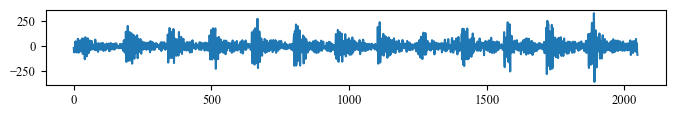

In [6]:
x = df1.values[:2048,0]
plt.figure(figsize=(8,1),dpi=100)
plt.plot(x)
plt.show()

In [7]:
del df0, df1

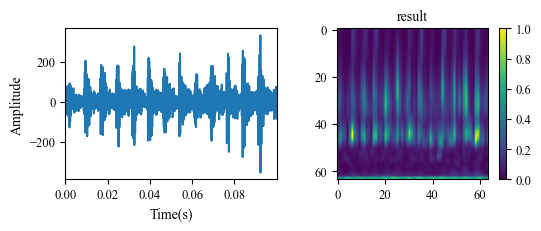

In [8]:
def get_cwt_map(sig, Fs,  need_show=False):
    '''
    sig:一维的信号，Fs：信号的采样率
    plt.imshow()显示 np.array 是彩色的，显示 PIL.Image.Image 时，是黑白'''
    Ts = 1 / Fs                             # 采样周期
    t = np.arange( len(sig) ) * Ts          # 时间

    # 2023-3-22
    wavename = 'cmor1.5-1'                  # 小波基函数： 'cgau8'  'cmor1.5-1'
    fc = pywt.central_frequency(wavename)   # 小波中心频率，标准化的中心频率
    scale_num = 256                         # 小波变换所需的尺度数量

    max_real_F = Fs/2                       # 小波变换结果的频率范伟，最大不超过采样频率的一半
    target_F = np.linspace(1,               # 令真实频率为（1z~Fs/2）的等间隔取样scale_num个
                         max_real_F, 
                         scale_num-1 )
    target_F = target_F[::-1]
    scales = fc*Fs / target_F               # 生成scale_num个尺度，非等间隔

    [generated_cwt, generated_F] = pywt.cwt(data = sig, 
                                      scales = scales, 
                                      wavelet = wavename,
                                      sampling_period=Ts)
    
    assert sum(target_F-generated_F)<1e-6   # 生成的频率，应该和原定的目标频率一样，由于计算精度应该有很小的差距
#     print('generated_cwt.shape,  generated_cwt.dtype', generated_cwt.shape,  generated_cwt.dtype )
    
    cwt = abs(generated_cwt)                 # (256,  2048)
    img0 = Image.fromarray( cwt )            # (2048, 256)
    img1 = img0.resize(size = (64, 64) )     # (64,   64)
    
    result = np.array(img1)
    result = (result-np.min(result)) / (np.max(result)-np.min(result)+1e-6)  # (64,   64),取值范伟是（0~1）
    
#     print(img0)
#     print('CWT的   \t 最小={}，\t 最大={}'.format(np.min(cwt),np.max(cwt)))
#     print('IMG的   \t 最小={}，\t 最大={}'.format(np.min(img0),np.max(img0)))
#     print('压缩图的 \t 最小={}，\t 最大={}'.format(np.min(img1),np.max(img1)))
#     print('归一化的 \t 最小={}，\t 最大={}'.format(np.min(result),np.max(result)))
    
    dpi = 100
    if need_show:
#         plt.figure(figsize=(8, 1),dpi=dpi)
#         plt.plot(t, sig)
#         plt.xlim(0, t[-1])
#         plt.xlabel('Time(s)' )
#         plt.ylabel('Amplitude' )
#         plt.show()

#         plt.figure(figsize=(8, 1),dpi=dpi)
#         plt.contourf(t, generated_F, cwt)
#         plt.ylabel('Frequency(Hz)' )
#         plt.xlabel('Time(s)' )
# #         plt.subplots_adjust(hspace=0.4)
#         plt.colorbar()
#         plt.show()
        
#         plt.figure(figsize=(8, 1),dpi=dpi)
#         plt.imshow(cwt)
#         # plt.axis('off')
#         plt.title('cwt')
#         plt.colorbar()
#         plt.show()
        
#         plt.figure(figsize=(8, 1),dpi=dpi)
#         plt.imshow(np.array(img0))
#         # plt.axis('off')
#         plt.title('img0')
#         plt.colorbar()
#         plt.show()
        
        
#         plt.figure(figsize=(2, 2),dpi=dpi)
#         plt.imshow(np.array(img1) )
#         # plt.axis('off')
#         plt.title('img1')
#         plt.colorbar()
#         plt.show()
        
#         plt.figure(figsize=(2, 2),dpi=dpi)
#         plt.imshow( result )
#         # plt.axis('off')
#         plt.title('result')
#         plt.colorbar()
#         plt.show()
    
        plt.figure(figsize=(6, 2),dpi=dpi)
        plt.subplot(1,2,1)
        plt.plot(t, sig)
        plt.xlim(0, t[-1])
        plt.xlabel('Time(s)' )
        plt.ylabel('Amplitude' )
        
        plt.subplot(1,2,2)
        plt.imshow( result )
        # plt.axis('off')
        plt.title('result')
        plt.colorbar()
        plt.show()
    return result

CWT_SAVE_PATH = 'F:\\Data\\IT\\'
cwt = get_cwt_map(       sig = x, 
                         Fs  =20*1024,  
                         need_show=True)  

In [9]:
cwt = get_cwt_map( sig= x,  Fs=1024*20,     )  
cwt.shape, np.min(cwt), np.max(cwt)

((64, 64), 0.0, 1.0)

# BJUT

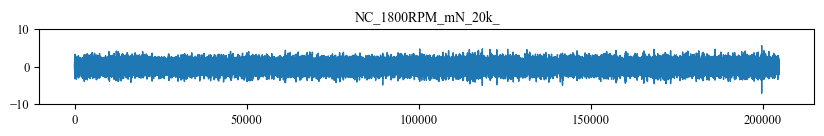

0	F:\Data\g_22_4_17\normal\1800RPM\mN\20k.csv	(204800, 1)	(204800,)	500	5.049561960189272
One Class Done!!! ********************************************************************************


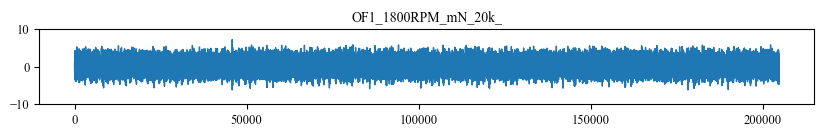

1	F:\Data\g_22_4_17\outer\0.5mm\1800RPM\mN\20k.csv	(204800, 1)	(204800,)	500	6.939414014272341
One Class Done!!! ********************************************************************************


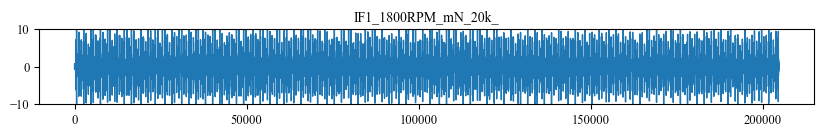

2	F:\Data\g_22_4_17\inner\0.5mm\1800RPM\mN\20k.csv	(204800, 1)	(204800,)	500	12.24565868200839
One Class Done!!! ********************************************************************************


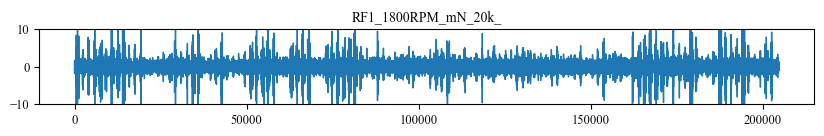

3	F:\Data\g_22_4_17\roller\0.5mm\1800RPM\mN\20k.csv	(204800, 1)	(204800,)	500	13.005300447019152
One Class Done!!! ********************************************************************************


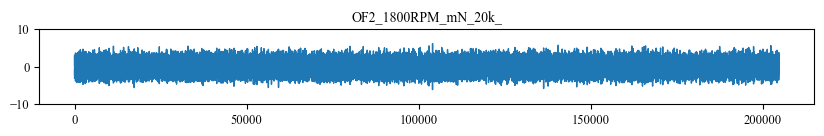

4	F:\Data\g_22_4_17\outer\2.0mm\1800RPM\mN\20k.csv	(204800, 1)	(204800,)	500	5.729094580314407
One Class Done!!! ********************************************************************************


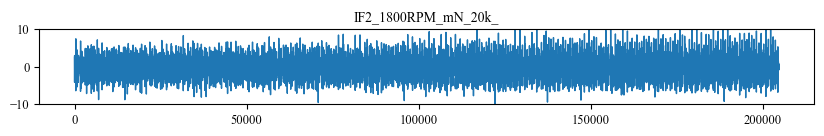

5	F:\Data\g_22_4_17\inner\2.0mm\1800RPM\mN\20k.csv	(204800, 1)	(204800,)	500	11.360678291688252
One Class Done!!! ********************************************************************************


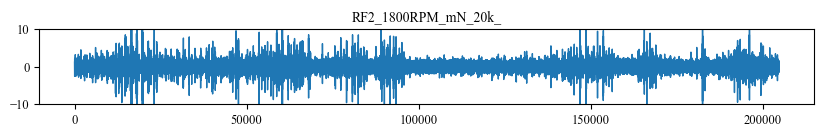

6	F:\Data\g_22_4_17\roller\2.0mm\1800RPM\mN\20k.csv	(204800, 1)	(204800,)	500	13.873498791849297
One Class Done!!! ********************************************************************************
(3500, 2048) (3500,)


In [10]:
# 2023-3-20
def get_B2022(root_path, rotational_speed, radial_force, sampling_frequency, need_show=False):
    '''
    F:\Data\g_22_4_17\outer\2.0mm\1500RPM\mN\12k.csv
    'F:\\Data\\g_22_4_17\\normal\\1500RPM\\mN\\20k.csv'
    root_path//type//（fault_degree//）rotational_speed//radial_force//sampling_frequency.csv
    '''
    assert rotational_speed in ['1200RPM', '1500RPM', '1800RPM', '2100RPM', ]
    assert radial_force in ['0N', 'mN']  # mN = 1.1kN
    assert sampling_frequency in ['12k',     '16k',     '20k',     '48k', ]
    SFF = os.path.join(rotational_speed, radial_force,
                       sampling_frequency+'.csv')
    all_class_path_list = []
    all_class_path_list.append(os.path.join(root_path, 'normal',          SFF))

    all_class_path_list.append(os.path.join(root_path, 'outer',  '0.5mm', SFF))
    all_class_path_list.append(os.path.join(root_path, 'inner',  '0.5mm', SFF))
    all_class_path_list.append(os.path.join(root_path, 'roller', '0.5mm', SFF))

    all_class_path_list.append(os.path.join(root_path, 'outer',  '2.0mm', SFF))
    all_class_path_list.append(os.path.join(root_path, 'inner',  '2.0mm', SFF))
    all_class_path_list.append(os.path.join(root_path, 'roller', '2.0mm', SFF))

#     print(all_class_path_list)

    data = []
    labels = []
    s, f = int(rotational_speed[:-3]),  int(sampling_frequency[:-1])*1024,
    for i, path in enumerate(all_class_path_list):
        # df = 215045 rows × 5 columns, 前面的部分数据是没用的
        df = pd.read_csv(path, skiprows=10245, header=None)  # 204800 rows × 1 columns
        d = df.values.reshape(-1)

        if need_show:
            #    画图   画图   画图   画图   画图   画图   画图   画图
            a = 10
            plt.figure(figsize=(10, 1), dpi=100)
            x = d
            plt.plot(normalF(x),  linewidth=1)
            HC = Health_status[i]
            bearing_id = '''{}_{}_{}_{}_'''.format(HC, rotational_speed, radial_force, sampling_frequency, )

            plt.title(bearing_id )
            plt.ylim(-a,  a)
    #         plt.savefig('./save/B2022/B2022_'+bearing_id+str(rms)[:6]+'.png',bbox_inches='tight')
            plt.show()
            #    画图   画图   画图   画图   画图   画图   画图   画图

        # print(rotational_speed,sampling_frequency,s,f)
        samples = split_signal(d, sample_length=2048, strides=400)[:500] # 500/507 
        data.append(samples)
        labels.append([i]*len(samples))
        print(i, path, df.shape, d.shape, len(samples), np.max(samples), sep='\t')
        print('One Class Done!!!','*'*80 )    

    data   = np.concatenate(data)
    labels = np.concatenate(labels)
    return data, labels


data, labels = get_B2022(root_path='F:\\Data\\g_22_4_17\\',
                    rotational_speed='1800RPM',
                    radial_force='mN',
                    sampling_frequency='20k',
                    need_show=1)
print(data.shape, labels.shape)

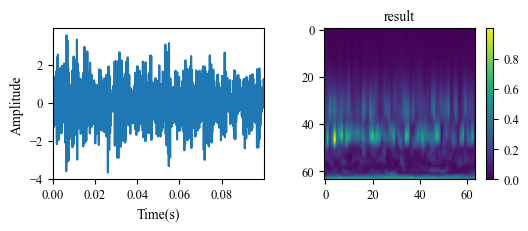

0 0 (2048,) (64, 64) NC
One Class Done!!! ********************************************************************************


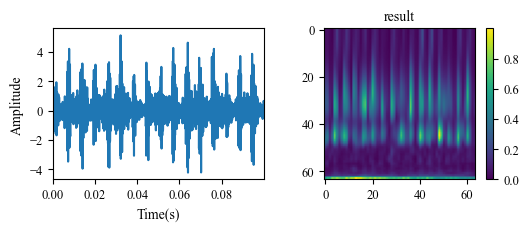

500 1 (2048,) (64, 64) OF1
One Class Done!!! ********************************************************************************


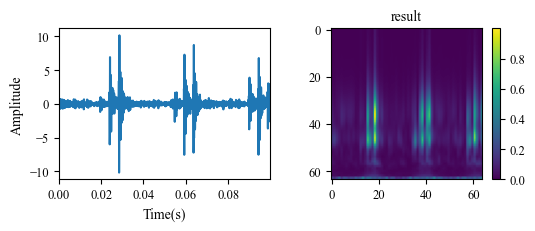

1000 2 (2048,) (64, 64) IF1
One Class Done!!! ********************************************************************************


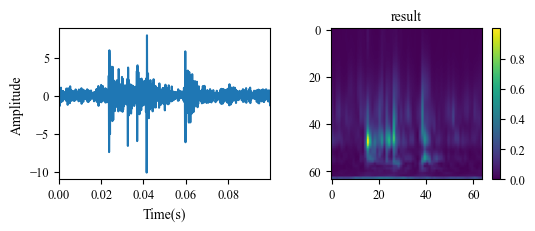

1500 3 (2048,) (64, 64) RF1
One Class Done!!! ********************************************************************************


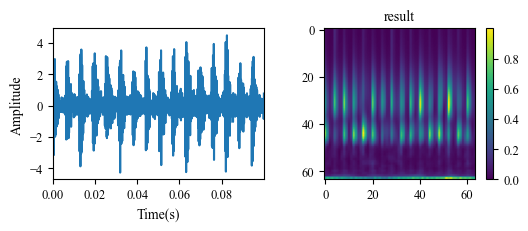

2000 4 (2048,) (64, 64) OF2
One Class Done!!! ********************************************************************************


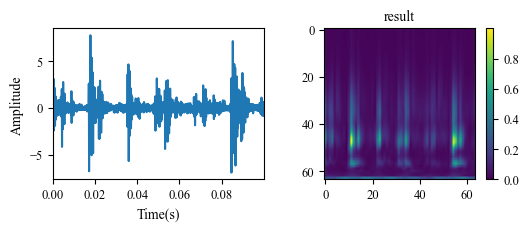

2500 5 (2048,) (64, 64) IF2
One Class Done!!! ********************************************************************************


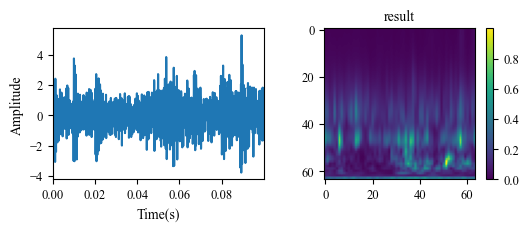

3000 6 (2048,) (64, 64) RF2
One Class Done!!! ********************************************************************************


In [11]:
for i in range(0,len(data),500):
    d  = data[i]
    lb = labels[i] 
    cwt = get_cwt_map( sig= d,  Fs=1024*20,   need_show=True ) 
    print(i,lb,d.shape,cwt.shape, Health_status[lb])
    print('One Class Done!!!','*'*80 )    


In [12]:
BJUT_Dataset_WC_dict = {'18mN':['1800RPM', 'mN', ],
                        '180N':['1800RPM', '0N', ],
                        '15mN':['1500RPM', 'mN', ],
                        '150N':['1500RPM', '0N', ],
                        '12mN':['1200RPM', 'mN', ],
                        '120N':['1200RPM', '0N', ],
                       }
BJUT_SAVE_PATH = 'F:\\Data\\MY\\BJUT\\'

for key in BJUT_Dataset_WC_dict.keys():
    print(key, BJUT_Dataset_WC_dict[key])
    speed, force = BJUT_Dataset_WC_dict[key]
    data, labels = get_B2022(root_path='F:\\Data\\g_22_4_17\\',
                                rotational_speed=speed,
                                radial_force=force,
                                sampling_frequency='20k',
                                need_show=0)
    
    # 生成 CWT ，并保存成csv
    for i in range(len(data)):
        sample = data[i]
        label  = labels[i]
        cwt    = get_cwt_map(  sig= sample,   Fs=20*1024 )
        
        dd    = np.concatenate([sample, cwt.reshape(-1)],axis=0)
        df    = pd.DataFrame({'sig_is_qian2048_cwt_ishou4096_original_shape_is64x64':dd})
        
        csv_name = '''[BJUT]____[{}]____[CLS_{:02d}]____[IDX_{:06d}].csv'''.format(key,label, i)
        path = BJUT_SAVE_PATH + csv_name
        df.to_csv(path, index=False)
        
        if i%500==0:
            print(i,sample.shape,label,cwt.shape)
            print(path)
#         break
#     break
    print('One working condition Done!!!','#'*80,'\n'*5)

18mN ['1800RPM', 'mN']
0	F:\Data\g_22_4_17\normal\1800RPM\mN\20k.csv	(204800, 1)	(204800,)	500	5.049561960189272
One Class Done!!! ********************************************************************************
1	F:\Data\g_22_4_17\outer\0.5mm\1800RPM\mN\20k.csv	(204800, 1)	(204800,)	500	6.939414014272341
One Class Done!!! ********************************************************************************
2	F:\Data\g_22_4_17\inner\0.5mm\1800RPM\mN\20k.csv	(204800, 1)	(204800,)	500	12.24565868200839
One Class Done!!! ********************************************************************************
3	F:\Data\g_22_4_17\roller\0.5mm\1800RPM\mN\20k.csv	(204800, 1)	(204800,)	500	13.005300447019152
One Class Done!!! ********************************************************************************
4	F:\Data\g_22_4_17\outer\2.0mm\1800RPM\mN\20k.csv	(204800, 1)	(204800,)	500	5.729094580314407
One Class Done!!! ********************************************************************************
5	F:\Data\

3000 (2048,) 6 (64, 64)
F:\Data\MY\BJUT\[BJUT]____[150N]____[CLS_06]____[IDX_003000].csv
One working condition Done!!! ################################################################################ 





12mN ['1200RPM', 'mN']
0	F:\Data\g_22_4_17\normal\1200RPM\mN\20k.csv	(204800, 1)	(204800,)	500	4.771064439749079
One Class Done!!! ********************************************************************************
1	F:\Data\g_22_4_17\outer\0.5mm\1200RPM\mN\20k.csv	(204800, 1)	(204800,)	500	7.971687920576408
One Class Done!!! ********************************************************************************
2	F:\Data\g_22_4_17\inner\0.5mm\1200RPM\mN\20k.csv	(204800, 1)	(204800,)	500	13.071224233537073
One Class Done!!! ********************************************************************************
3	F:\Data\g_22_4_17\roller\0.5mm\1200RPM\mN\20k.csv	(204800, 1)	(204800,)	500	11.722433482872589
One Class Done!!! ******************************************************************************

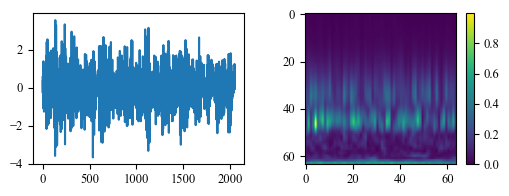

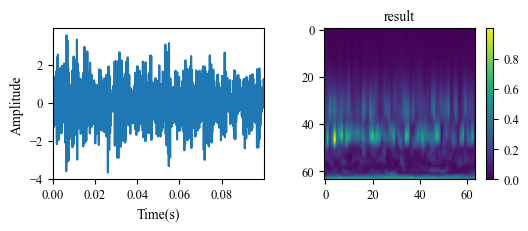

In [13]:
df = pd.read_csv('F:\Data\MY\BJUT\[BJUT]____[18mN]____[CLS_00]____[IDX_000000].csv')
xx = df.values.reshape(-1)
sig = xx[:2048]
cwt = xx[2048:].reshape(64,64)

plt.figure(figsize=(6, 2),dpi=100)
plt.subplot(1,2,1)
plt.plot( sig )

plt.subplot(1,2,2)
plt.imshow( cwt )
plt.colorbar()
plt.show()

cwt2 = get_cwt_map( sig= sig,  Fs=1024*20,   need_show=True ) 

assert np.sum(cwt-cwt2) < 1e-6

# CWRU

In [14]:
CWRU_path = 'F:\\Data\\CWRU\\best-CWRU\\'
mat_names = np.array(os.listdir(CWRU_path))
mat_names

array(['12k_Drive_End_B007_0_118.mat', '12k_Drive_End_B007_1_119.mat',
       '12k_Drive_End_B007_2_120.mat', '12k_Drive_End_B007_3_121.mat',
       '12k_Drive_End_B014_0_185.mat', '12k_Drive_End_B014_1_186.mat',
       '12k_Drive_End_B014_2_187.mat', '12k_Drive_End_B014_3_188.mat',
       '12k_Drive_End_B021_0_222.mat', '12k_Drive_End_B021_1_223.mat',
       '12k_Drive_End_B021_2_224.mat', '12k_Drive_End_B021_3_225.mat',
       '12k_Drive_End_B028_0_3005.mat', '12k_Drive_End_B028_1_3006.mat',
       '12k_Drive_End_B028_2_3007.mat', '12k_Drive_End_B028_3_3008.mat',
       '12k_Drive_End_IR007_0_105.mat', '12k_Drive_End_IR007_1_106.mat',
       '12k_Drive_End_IR007_2_107.mat', '12k_Drive_End_IR007_3_108.mat',
       '12k_Drive_End_IR014_0_169.mat', '12k_Drive_End_IR014_1_170.mat',
       '12k_Drive_End_IR014_2_171.mat', '12k_Drive_End_IR014_3_172.mat',
       '12k_Drive_End_IR021_0_209.mat', '12k_Drive_End_IR021_1_210.mat',
       '12k_Drive_End_IR021_2_211.mat', '12k_Drive_End_IR021_3_

In [15]:
print(mat_names[['normal' in mat for mat in mat_names]  ])
print(mat_names[['12k_Drive_End_OR007@6_0_' in mat for mat in mat_names]  ])
print(mat_names[['12k_Drive_End_IR014_0_' in mat for mat in mat_names]  ])
print(mat_names[['12k_Drive_End_B021_0_' in mat for mat in mat_names]  ])

['normal_0_97.mat' 'normal_1_98.mat' 'normal_2_99.mat' 'normal_3_100.mat']
['12k_Drive_End_OR007@6_0_130.mat']
['12k_Drive_End_IR014_0_169.mat']
['12k_Drive_End_B021_0_222.mat']


In [16]:
type(mat_names[['12k_Drive_End_B021_0_' in mat for mat in mat_names]  ]) is  np.ndarray

True

In [17]:
type(mat_names[['12k_Drive_End_B021_0_' in mat for mat in mat_names]  ][0]) 

numpy.str_

In [18]:
mat_names[['12k_Drive_End_B021_0_' in mat for mat in mat_names]  ][0]

'12k_Drive_End_B021_0_222.mat'

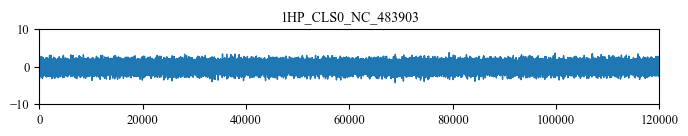

0	F:\Data\CWRU\best-CWRU\normal_1_98.mat	(483903,)	(120000,)	(500, 2048)	3.7659443273501196
One Class Done!!! ********************************************************************************


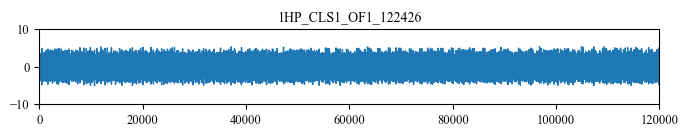

1	F:\Data\CWRU\best-CWRU\12k_Drive_End_OR007@6_1_131.mat	(122426,)	(120000,)	(500, 2048)	5.385219984878381
One Class Done!!! ********************************************************************************


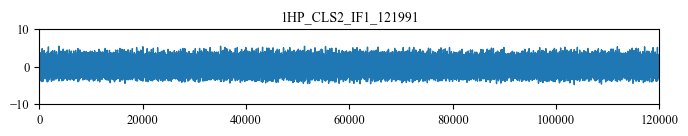

2	F:\Data\CWRU\best-CWRU\12k_Drive_End_IR007_1_106.mat	(121991,)	(120000,)	(500, 2048)	5.433926376075183
One Class Done!!! ********************************************************************************


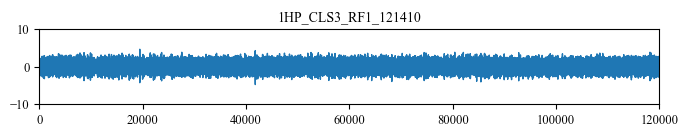

3	F:\Data\CWRU\best-CWRU\12k_Drive_End_B007_1_119.mat	(121410,)	(120000,)	(500, 2048)	4.531151700190211
One Class Done!!! ********************************************************************************


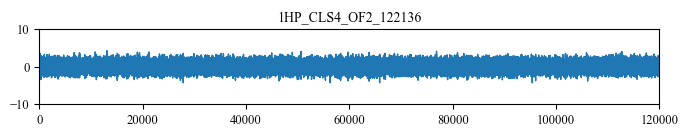

4	F:\Data\CWRU\best-CWRU\12k_Drive_End_OR014@6_1_198.mat	(122136,)	(120000,)	(500, 2048)	4.256806056652925
One Class Done!!! ********************************************************************************


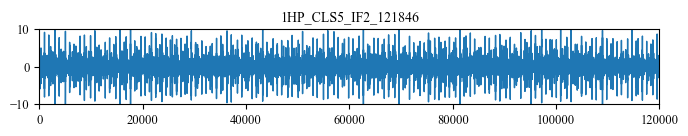

5	F:\Data\CWRU\best-CWRU\12k_Drive_End_IR014_1_170.mat	(121846,)	(120000,)	(500, 2048)	11.814897559071834
One Class Done!!! ********************************************************************************


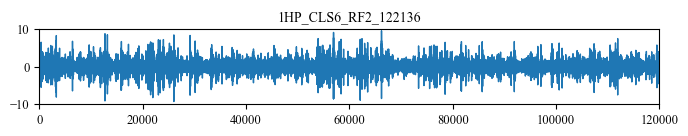

6	F:\Data\CWRU\best-CWRU\12k_Drive_End_B014_1_186.mat	(122136,)	(120000,)	(500, 2048)	9.137419819964219
One Class Done!!! ********************************************************************************


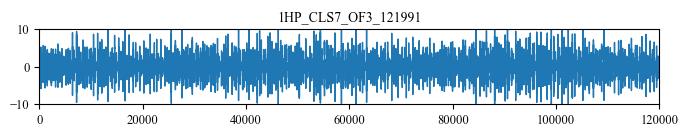

7	F:\Data\CWRU\best-CWRU\12k_Drive_End_OR021@6_1_235.mat	(121991,)	(120000,)	(500, 2048)	10.9875632508288
One Class Done!!! ********************************************************************************


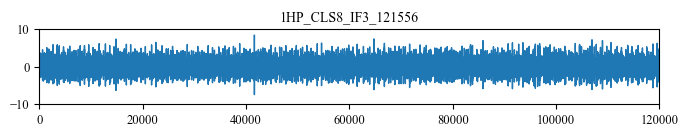

8	F:\Data\CWRU\best-CWRU\12k_Drive_End_IR021_1_210.mat	(121556,)	(120000,)	(500, 2048)	8.144446700776797
One Class Done!!! ********************************************************************************


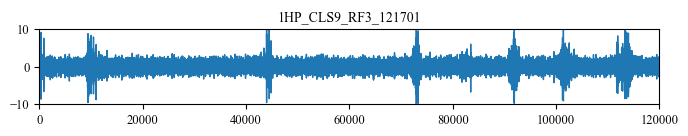

9	F:\Data\CWRU\best-CWRU\12k_Drive_End_B021_1_223.mat	(121701,)	(120000,)	(500, 2048)	8.668016462140562
One Class Done!!! ********************************************************************************


In [19]:
# 2023-3-22
def get_CWRU( hp=0, need_show=False ):
    '''
    加载制定工况下的10类故障数据：NC,OF1,IF1,RF1,OF2,IF2,RF2,OF3,IF3,RF3
    1、根据给定的工况找到目标的mat文件，比如：12k_Drive_End_B007_0_118.mat，
    2、读取mat文件，使用驱动端数据，split成  10类@500样本@2048长度
    '''
    assert hp in [0,1,2,3]
    
    # 得到 NC,OF1,IF1,RF1,OF2,IF2,RF2,OF3,IF3,RF3的 mat key
    # 由于每个文件名后面有个不可推算的，数字标识，所以只能用 mat key 去匹配，以找到mat name
    mat_key_list = []
    mat_key_list.append('normal_{}_'.format(hp))                     
    
    mat_key_list.append('12k_Drive_End_OR007@6_{}_'.format(hp))
    mat_key_list.append('12k_Drive_End_IR007_{}_'.format(hp))
    mat_key_list.append('12k_Drive_End_B007_{}_'.format(hp))
    
    mat_key_list.append('12k_Drive_End_OR014@6_{}_'.format(hp))
    mat_key_list.append('12k_Drive_End_IR014_{}_'.format(hp))
    mat_key_list.append('12k_Drive_End_B014_{}_'.format(hp))
    
    mat_key_list.append('12k_Drive_End_OR021@6_{}_'.format(hp))
    mat_key_list.append('12k_Drive_End_IR021_{}_'.format(hp))
    mat_key_list.append('12k_Drive_End_B021_{}_'.format(hp))
    
    data   = []
    labels = []
    for i,mat_key in enumerate(mat_key_list):
        mat_name = mat_names[ [mat_key in mat for mat in mat_names]  ]
        assert type(mat_name) is np.ndarray and len(mat_name)==1
        
        mat_name = mat_name[0]
        assert type(mat_name) is np.str_ 
        assert '12k_Drive_End_' in mat_name or 'normal_' in mat_name
        
        path = os.path.join(CWRU_path, mat_name)
#         print(i, mat_key, mat_name, path, sep='\t#    ')
        
        
        # 读数据
        mat = scio.loadmat( path )
        
        keys = np.array(list(mat.keys()))
        is_de_in_keys = ['DE' in k for k in keys]
        de_key        = keys[is_de_in_keys][0]
        # print(de_key)
        
        DE = mat[de_key].reshape(-1)
        N = 120000
        x  = DE[:N]
        assert len(x)==N
        # print(DE.shape, end='\t')

        if need_show:
            #    画图   画图   画图   画图   画图   画图   画图   画图
            a = 10
            plt.figure(figsize=(8,1),dpi=100)
            title = '{}HP_CLS{}_{}_{}'.format(hp,i,Health_status[i],len(DE) )
            plt.plot( normalF(x), linewidth=1)
            plt.title(  title  )
            plt.ylim(-a, a)
            plt.xlim(0,120000)
            plt.show()
            #    画图   画图   画图   画图   画图   画图   画图   画图
        
        samples = split_signal(x, sample_length=2048, strides=235)[:500] # 500/502 
        data.append(samples)
        labels.append([i]*len(samples))
        print(i, path, DE.shape, x.shape, samples.shape, np.max(samples), sep='\t')
        print('One Class Done!!!','*'*80 )    
 
        
    data   = np.concatenate(data)
    labels = np.concatenate(labels)
    return data, labels


data, labels = get_CWRU( hp=1, need_show=True)

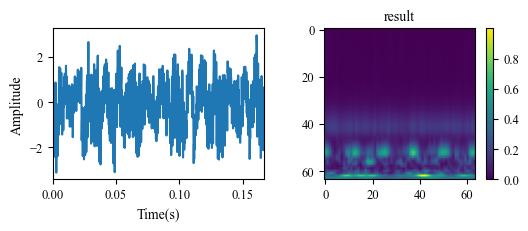

0 0 (2048,) (64, 64) NC
One Class Done!!! ********************************************************************************


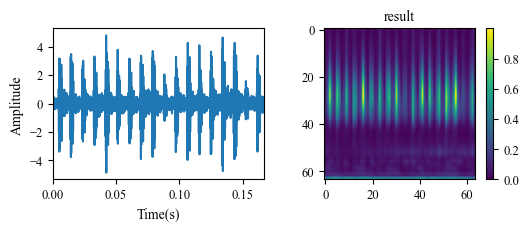

500 1 (2048,) (64, 64) OF1
One Class Done!!! ********************************************************************************


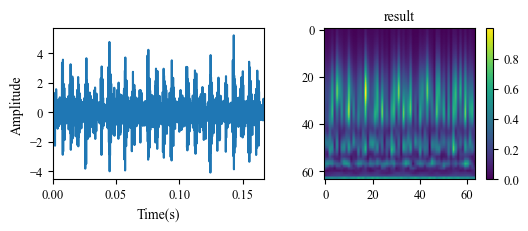

1000 2 (2048,) (64, 64) IF1
One Class Done!!! ********************************************************************************


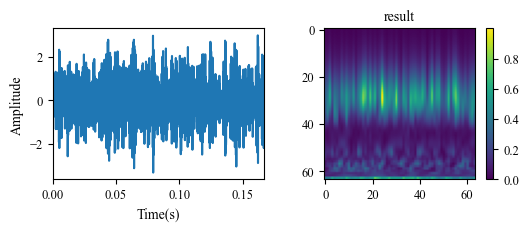

1500 3 (2048,) (64, 64) RF1
One Class Done!!! ********************************************************************************


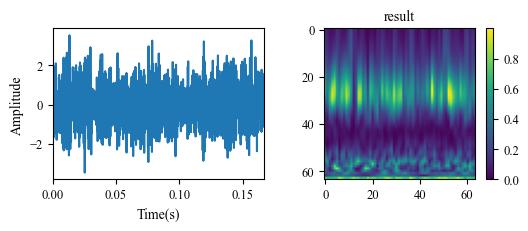

2000 4 (2048,) (64, 64) OF2
One Class Done!!! ********************************************************************************


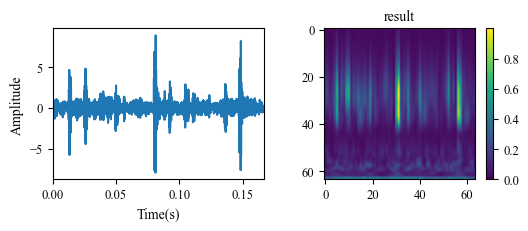

2500 5 (2048,) (64, 64) IF2
One Class Done!!! ********************************************************************************


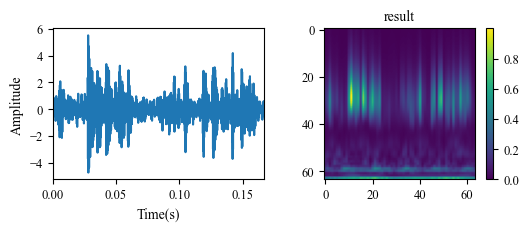

3000 6 (2048,) (64, 64) RF2
One Class Done!!! ********************************************************************************


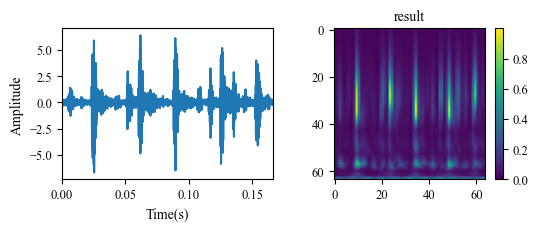

3500 7 (2048,) (64, 64) OF3
One Class Done!!! ********************************************************************************


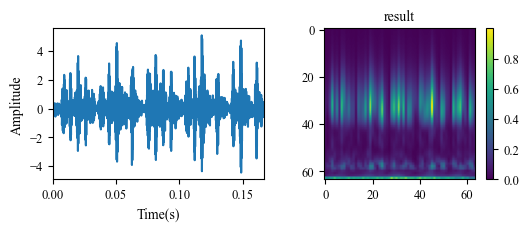

4000 8 (2048,) (64, 64) IF3
One Class Done!!! ********************************************************************************


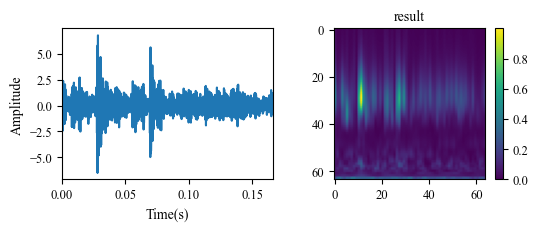

4500 9 (2048,) (64, 64) RF3
One Class Done!!! ********************************************************************************


In [20]:
for i in range(0,len(data),500):
    d  = data[i]
    lb = labels[i] 
    cwt = get_cwt_map( sig= d,  Fs=1024*12,   need_show=True ) 
    print(i,lb,d.shape,cwt.shape, Health_status[lb])
    print('One Class Done!!!','*'*80 )    

    

In [22]:
CWRU_Dataset_WC_dict = {'0HP': 0,
                        '1HP': 1,
                        '2HP': 2,
                        '3HP': 3,
                       }
CWRU_SAVE_PATH = 'F:\\Data\\MY\\CWRU\\'

for key in CWRU_Dataset_WC_dict.keys():
    print(key, CWRU_Dataset_WC_dict[key])
    
    hp = CWRU_Dataset_WC_dict[key]
    data, labels = get_CWRU( hp=hp, need_show=0)
    
    # 生成 CWT ，并保存成csv
    for i in range(len(data)):
        sample = data[i]
        label  = labels[i]
        cwt    = get_cwt_map(  sig= sample,   Fs=12*1024 )
        
        dd    = np.concatenate([sample, cwt.reshape(-1)],axis=0)
        df    = pd.DataFrame({'sig_is_qian2048_cwt_ishou4096_original_shape_is64x64':dd})
        
        csv_name = '''[CWRU]____[{}]____[CLS_{:02d}]____[IDX_{:06d}].csv'''.format(key,label, i)
        path = CWRU_SAVE_PATH + csv_name
        df.to_csv(path, index=False)
        
        if i%500==0:
            print(i,sample.shape,label,cwt.shape)
            print(path)
#         break
#     break
    print('One working condition Done!!!','#'*80,'\n'*5)

0HP 0
0	F:\Data\CWRU\best-CWRU\normal_0_97.mat	(243938,)	(120000,)	(500, 2048)	4.092251042746769
One Class Done!!! ********************************************************************************
1	F:\Data\CWRU\best-CWRU\12k_Drive_End_OR007@6_0_130.mat	(121991,)	(120000,)	(500, 2048)	5.352067240260833
One Class Done!!! ********************************************************************************
2	F:\Data\CWRU\best-CWRU\12k_Drive_End_IR007_0_105.mat	(121265,)	(120000,)	(500, 2048)	5.969419385271116
One Class Done!!! ********************************************************************************
3	F:\Data\CWRU\best-CWRU\12k_Drive_End_B007_0_118.mat	(122571,)	(120000,)	(500, 2048)	4.286677195675256
One Class Done!!! ********************************************************************************
4	F:\Data\CWRU\best-CWRU\12k_Drive_End_OR014@6_0_197.mat	(121846,)	(120000,)	(500, 2048)	5.076234995107725
One Class Done!!! ******************************************************************

1000 (2048,) 2 (64, 64)
F:\Data\MY\CWRU\[CWRU]____[2HP]____[CLS_02]____[IDX_001000].csv
1500 (2048,) 3 (64, 64)
F:\Data\MY\CWRU\[CWRU]____[2HP]____[CLS_03]____[IDX_001500].csv
2000 (2048,) 4 (64, 64)
F:\Data\MY\CWRU\[CWRU]____[2HP]____[CLS_04]____[IDX_002000].csv
2500 (2048,) 5 (64, 64)
F:\Data\MY\CWRU\[CWRU]____[2HP]____[CLS_05]____[IDX_002500].csv
3000 (2048,) 6 (64, 64)
F:\Data\MY\CWRU\[CWRU]____[2HP]____[CLS_06]____[IDX_003000].csv
3500 (2048,) 7 (64, 64)
F:\Data\MY\CWRU\[CWRU]____[2HP]____[CLS_07]____[IDX_003500].csv
4000 (2048,) 8 (64, 64)
F:\Data\MY\CWRU\[CWRU]____[2HP]____[CLS_08]____[IDX_004000].csv
4500 (2048,) 9 (64, 64)
F:\Data\MY\CWRU\[CWRU]____[2HP]____[CLS_09]____[IDX_004500].csv
One working condition Done!!! ################################################################################ 





3HP 3
0	F:\Data\CWRU\best-CWRU\normal_3_100.mat	(485643,)	(120000,)	(500, 2048)	3.96426456404546
One Class Done!!! ****************************************************************

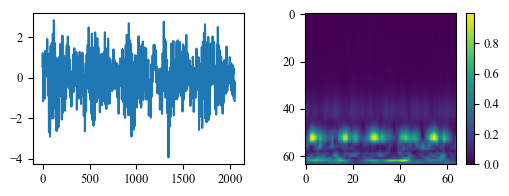

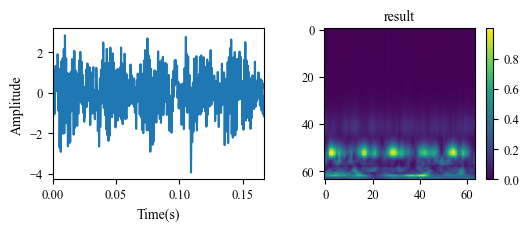

In [23]:
df = pd.read_csv('F:\Data\MY\CWRU\[CWRU]____[0HP]____[CLS_00]____[IDX_000000].csv')
xx = df.values.reshape(-1)
sig = xx[:2048]
cwt = xx[2048:].reshape(64,64)

plt.figure(figsize=(6, 2),dpi=100)
plt.subplot(1,2,1)
plt.plot( sig )

plt.subplot(1,2,2)
plt.imshow( cwt )
plt.colorbar()
plt.show()

cwt2 = get_cwt_map( sig= sig,  Fs=1024*12,   need_show=True ) 

assert np.sum(cwt-cwt2) < 1e-6

In [24]:
del data

# IMS

In [25]:
IMS_health_df = pd.DataFrame({
                                'Set_1':['  ', '  ', 'IF', 'RF'],
                                'Set_2':['OF', '  ', '  ', '  '],
                                'Set_3':['  ', '  ', 'OF', '  ']
                            },
                            index = ['Bearing_1','Bearing_2','Bearing_3','Bearing_4']
                            )
IMS_health_df

,Set_1,Set_2,Set_3
Bearing_1,,OF,
Bearing_2,,,
Bearing_3,IF,,OF
Bearing_4,RF,,


In [26]:
'''IMS轴承数据集：2000RPM，26.69kN，20kHz（k是1024，不是1000）  
6000 lbs * 4.44822 N/lb = 26,689.32 N
# 6000 lbs 是来自官方文档说的负载：Readme Document for IMS Bearing Data
# 源自论文：ANALYSIS OF NASA BEARING DATASET OF THE UNIVERSITY OF CINCINNATI BY MEANS OF HJORTH’S PARAMETERS

正常 = set2_bearing_1，最前10个文件, 0.074 - 0.079
外圈 = set2_bearing_1，最后10个文件, 0.32  - 0.67    
内圈 = set1_bearing_3，最后10个文件, 0.27  - 0.53
滚子 = set1_bearing_4，最后10个文件, 0.20  - 0.23

注意：set2_bearing_1的最后3个文件是错误值，应该是机器停止运行了，但数据依旧在采集
注意：set2_bearing_1的最后3个文件是错误值，应该是机器停止运行了，但数据依旧在采集
注意：set2_bearing_1的最后3个文件是错误值，应该是机器停止运行了，但数据依旧在采集
'''

set1p = 'F:/Data/IMS/1st_test/'
set2p = 'F:/Data/IMS/2nd_test/'

health2idx = {'OF':[2-1, 1-1],     # 列表里面第一个数，表示数据集的索引，set1的索引是（1-1），即0
              'IF':[1-1, 3-1],     # 列表里面第二个数，表示轴承  的索引，轴承3的索引是（3-1），即2
              'RF':[1-1, 4-1]}

set1_needed_bearings = [3-1,4-1]
set2_needed_bearings = [1-1]
setx_needed_bearings_list = [set1_needed_bearings,set2_needed_bearings]

set1_files = [os.path.join(set1p, p) for p in os.listdir(set1p)]
set2_files = [os.path.join(set2p, p) for p in os.listdir(set2p)]
setx_files_list = [set1_files, set2_files]

print(len(set1_files), set1_files[::1000])
print(len(set2_files), set2_files[::1000])

2156 ['F:/Data/IMS/1st_test/2003.10.22.12.06.24', 'F:/Data/IMS/1st_test/2003.11.15.05.18.46', 'F:/Data/IMS/1st_test/2003.11.24.01.11.24']
984 ['F:/Data/IMS/2nd_test/2004.02.12.10.32.39']


In [27]:
pd.read_csv(set1_files[0],header=None,sep='\t').iloc[:,::2]

,0,2,4,6
0,-0.022,-0.183,-0.105,-0.129
1,-0.105,-0.164,-0.049,-0.115
2,-0.183,-0.195,-0.005,-0.171
3,-0.178,-0.159,-0.100,-0.112
4,-0.208,-0.261,-0.151,-0.063
...,...,...,...,...
20475,-0.022,0.085,-0.200,-0.134
20476,0.024,0.042,-0.159,-0.227
20477,-0.193,-0.071,-0.237,-0.151
20478,-0.115,-0.078,-0.027,-0.151


In [28]:
pd.read_csv(set2_files[0],header=None,sep='\t').iloc[:,::1]

,0,1,2,3
0,-0.049,-0.071,-0.132,-0.010
1,-0.042,-0.073,-0.007,-0.105
2,0.015,0.000,0.007,0.000
3,-0.051,0.020,-0.002,0.100
4,-0.107,0.010,0.127,0.054
...,...,...,...,...
20475,0.049,-0.051,-0.039,-0.044
20476,0.037,0.061,0.115,0.007
20477,-0.012,0.007,0.056,-0.007
20478,-0.012,0.093,0.017,-0.044


In [29]:
set_data_list = []
for set_idx in range(2):
    setx_files = setx_files_list[set_idx]

    # IMS的数据集1中的每个轴承有两个传感器记录X,Y方向的振动信号，数据集2，3中仅有1个传感器
    # 在这里为了保持一致性，我们仅取数据集1中的第一个通道的数据
    per_bearing_sensor_number = 2 if set_idx == 0 else 1
    
    setx_nbearing_data_list = []
    for i,fp in enumerate(setx_files[:]):
        d = pd.read_csv(fp, header=None, sep='\t'
                        ).iloc[:, ::per_bearing_sensor_number].values                   # (20480,4)
        
        needed_idx_list = setx_needed_bearings_list[set_idx]                            # (n,)
        d        = d[:, needed_idx_list]                                                # (20480,n)
        
        setx_nbearing_data_list.append(d)
        if i%500==0:
            print(set_idx, i, int(i/len(setx_files)*10000)/100, sep='\t')
        
    setx_data = np.array(setx_nbearing_data_list)
    set_data_list.append(setx_data)
    
    print(set_idx, setx_data.shape,)
    
del  setx_data,   

0	0	0.0
0	500	23.19
0	1000	46.38
0	1500	69.57
0	2000	92.76
0 (2156, 20480, 2)
1	0	0.0
1	500	50.81
1 (984, 20480, 1)


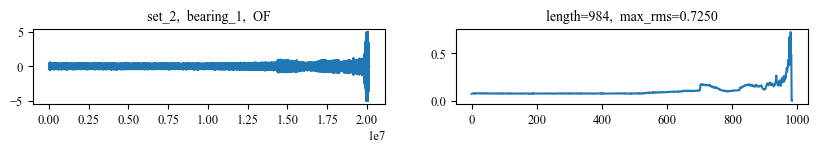

OF (984, 20480) [0.4476727901067398, 0.6721374879698163, 0.530956128967989, 0.4459182473835416, 0.38697483181595205, 0.7250014697250727, 0.46201166565273954, 0.4838353953514789, 0.002103011233921493, 0.001532732063383878]


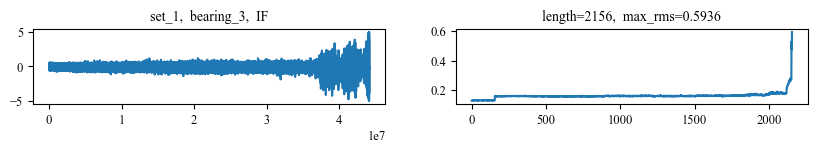

IF (2156, 20480) [0.2766132981243287, 0.27715855286773017, 0.27978249460448623, 0.2742740844277342, 0.278471863234477, 0.27564510741919696, 0.49617328614387585, 0.5315690219507305, 0.4744469256449095, 0.5936098712110663]


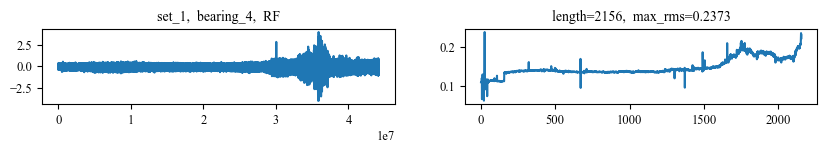

RF (2156, 20480) [0.20594573200542418, 0.20460934493126928, 0.20504323596081206, 0.2079563764162751, 0.20432903355881202, 0.20745455486439524, 0.22231081768146851, 0.23452204116664332, 0.2193165942327652, 0.2291760908455207]


In [30]:
IMS_3_fault_bearing_rtf_data = {
    'OF': set_data_list[1][:,:,0],
    'IF': set_data_list[0][:,:,0],
    'RF': set_data_list[0][:,:,1],
}

rtf_rms_dict = {}
for key in IMS_3_fault_bearing_rtf_data.keys():
    rtf_data = IMS_3_fault_bearing_rtf_data[key]

    
    rtf_rms = [np.sqrt(np.mean(np.square(i))) for i in rtf_data]
    assert len(rtf_rms) == len(rtf_data)
    rtf_rms_dict[key] = rtf_rms
           
#     k=20
#     rtf_rms  = np.convolve(a=rtf_rms,v=[1/k for i in range(k)],mode='same')

    plt.figure(figsize=(10,1),dpi=100)
    plt.subplot(1,2,1)
    plt.plot(rtf_data.reshape(-1))
    idx = health2idx[key]
    plt.title('set_{},  bearing_{},  {}'.format(idx[0]+1, idx[1]+1, key))
    plt.subplot(1,2,2)
    plt.plot(rtf_rms)
    plt.title('length={},  max_rms={:.4f}'.format( len(rtf_rms), np.max(rtf_rms)))
    plt.show()
    
    print(key, rtf_data.shape, rtf_rms[-10:] )


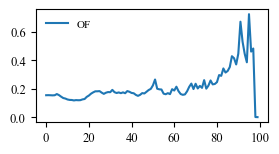

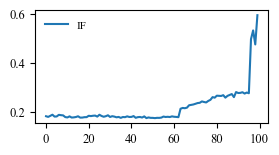

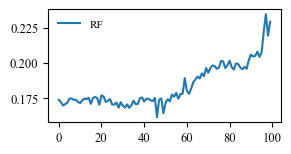

In [31]:
for key in rtf_rms_dict.keys():
    plt.figure(figsize=(3,1.5),dpi=100)
    plt.plot(rtf_rms_dict[key][-100:],label=key)
    plt.legend()
    plt.show()

In [32]:
IMS_data = []

data = IMS_3_fault_bearing_rtf_data['OF'][:500,:2048]      # 直接够500个样本
IMS_data.append(data)

data = IMS_3_fault_bearing_rtf_data['OF'][-20:-10,:]       # 10个样本，每个里面抽出50个
samples = []
for i,sig in enumerate(data):
    sample = split_signal(sig,2048,strides=370)            # 每个20480里抽出50个2048
    samples.append(sample)
#     print(i, sig.shape, sample.shape)
data = np.concatenate(samples)                             # (500,2048)
IMS_data.append(data)


data = IMS_3_fault_bearing_rtf_data['IF'][-20:-10,:]       # 10个样本，每个里面抽出50个
samples = []
for i,sig in enumerate(data):
    sample = split_signal(sig,2048,strides=370)            # 每个20480里抽出50个2048
    samples.append(sample)
#     print(i, sig.shape, sample.shape)
data = np.concatenate(samples)                             # (500,2048)
IMS_data.append(data)


data = IMS_3_fault_bearing_rtf_data['RF'][-20:-10,:]       # 10个样本，每个里面抽出50个
samples = []
for i,sig in enumerate(data):
    sample = split_signal(sig,2048,strides=370)            # 每个20480里抽出50个2048
    samples.append(sample)
#     print(i, sig.shape, sample.shape)
data = np.concatenate(samples)                             # (500,2048)
IMS_data.append(data)

data = np.concatenate(IMS_data)
labels = np.array([0]*500+[1]*500+[2]*500+[3]*500)
data.shape,labels[::100]

((2000, 2048),
 array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3]))

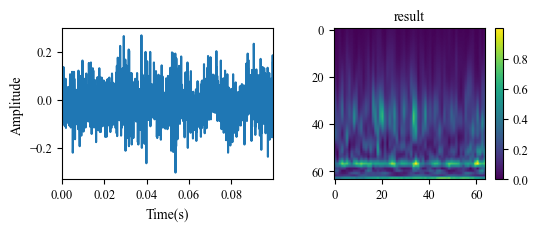

0 0 (2048,) (64, 64) NC
One Class Done!!! ********************************************************************************


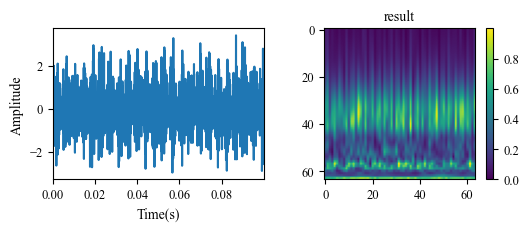

500 1 (2048,) (64, 64) OF1
One Class Done!!! ********************************************************************************


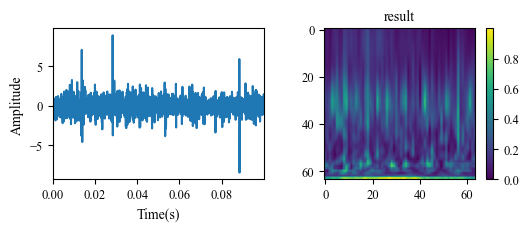

1000 2 (2048,) (64, 64) IF1
One Class Done!!! ********************************************************************************


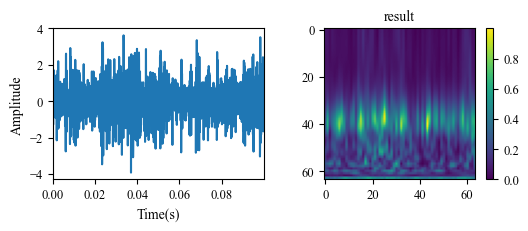

1500 3 (2048,) (64, 64) RF1
One Class Done!!! ********************************************************************************


In [33]:
for i in range(0,len(data),500):
    d  = data[i]
    lb = labels[i] 
    cwt = get_cwt_map( sig= d,  Fs=1024*20,   need_show=True ) 
    print(i,lb,d.shape,cwt.shape, Health_status[lb])
    print('One Class Done!!!','*'*80 )    

    

In [34]:
IMS_SAVE_PATH = 'F:\\Data\\MY\\IMS\\'

# 生成 CWT ，并保存成csv
for i in range(len(data)):
    sample = data[i]
    label  = labels[i]
    cwt    = get_cwt_map(  sig= sample,   Fs=20*1024 )

    dd    = np.concatenate([sample, cwt.reshape(-1)],axis=0)
    df    = pd.DataFrame({'sig_is_qian2048_cwt_ishou4096_original_shape_is64x64':dd})

    csv_name = '''[IMS]____[2000RMP_26.7kN]____[CLS_{:02d}]____[IDX_{:06d}].csv'''.format(label, i)
    path = IMS_SAVE_PATH + csv_name
    df.to_csv(path, index=False)

    if i%500==0:
        print(i,sample.shape,label,cwt.shape)
        print(path)
#     break
print('One working condition Done!!!','#'*80,'\n'*5)

0 (2048,) 0 (64, 64)
F:\Data\MY\IMS\[IMS]____[2000RMP_26.7kN]____[CLS_00]____[IDX_000000].csv
500 (2048,) 1 (64, 64)
F:\Data\MY\IMS\[IMS]____[2000RMP_26.7kN]____[CLS_01]____[IDX_000500].csv
1000 (2048,) 2 (64, 64)
F:\Data\MY\IMS\[IMS]____[2000RMP_26.7kN]____[CLS_02]____[IDX_001000].csv
1500 (2048,) 3 (64, 64)
F:\Data\MY\IMS\[IMS]____[2000RMP_26.7kN]____[CLS_03]____[IDX_001500].csv
One working condition Done!!! ################################################################################ 







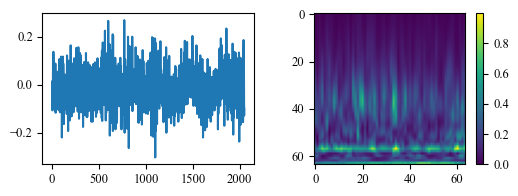

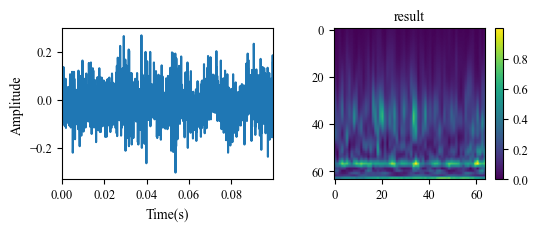

In [35]:
df = pd.read_csv('F:\Data\MY\IMS\[IMS]____[2000RMP_26.7kN]____[CLS_00]____[IDX_000000].csv')
xx = df.values.reshape(-1)
sig = xx[:2048]
cwt = xx[2048:].reshape(64,64)

plt.figure(figsize=(6, 2),dpi=100)
plt.subplot(1,2,1)
plt.plot( sig )

plt.subplot(1,2,2)
plt.imshow( cwt )
plt.colorbar()
plt.show()

cwt2 = get_cwt_map( sig= sig,  Fs=1024*20,   need_show=True ) 

assert np.sum(cwt-cwt2) < 1e-6

# LAST